# Переобучение при глубоком обучении

## Комментарий
Имейте ввиду - при обучении глубоких нейросетей они должны инициализироваться со случайными весами, задавать им веса с помощью random seed не рекомендуется.
При небольшим количестве данных это приводит к тому, что обучение при каждом запуске идет по разному, с разными кривыми функций потерь. Иногда даже сеть с плохими данными "удачно" находит локальный или глобальный минимум и показывает хорошие метрики на тестовых данных. 
Признак хорошего обучения - кривые более-менее одинаковые при разных запусках. Если кривые то "плохие" то "хорошие" - модель переобучается!

In [109]:
from random import choices
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torch.utils.data as data_utils
from torch.nn.functional import normalize
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Сети очень простые, нет нужды применять GPU
device = "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
df = pd.read_csv('data/debernard2020data.csv', delimiter=',')
df.columns

Index(['sample_id', 'patient_cohort', 'sample_origin', 'age', 'sex',
       'diagnosis', 'stage', 'benign_sample_diagnosis', 'plasma_CA19_9',
       'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A'],
      dtype='object')

In [4]:
feature_columns = ['age', 'sex','plasma_CA19_9',
       'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A']

In [5]:
df.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [6]:
y = df['diagnosis']

y = y==3

sum(y)/len(y)

0.33728813559322035

In [7]:
X = df[feature_columns]
X['sex'] = X['sex']== 'F'
X.fillna(0, inplace=True)

C:\Users\demet\AppData\Local\Temp\ipykernel_6840\2437986156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['sex'] = X['sex']== 'F'
C:\Users\demet\AppData\Local\Temp\ipykernel_6840\2437986156.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [9]:
def make_loaders(X_train, y_train, X_test, y_test):
    X_train = torch.tensor(X_train.values.astype(float), dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test.values.astype(float), dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
    train_dataset = data_utils.TensorDataset(X_train, y_train)
    test_dataset = data_utils.TensorDataset(X_test, y_test)
    train_loader = data_utils.DataLoader(train_dataset, batch_size=10, shuffle=True)
    test_loader = data_utils.DataLoader(test_dataset, batch_size=10, shuffle=True)
    return([train_loader,test_loader])

In [10]:

loaders = make_loaders(X_train, y_train, X_test, y_test)

In [11]:
class Classifier(nn.Module):
    def __init__(self, n_input_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_input_features, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 8)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(8, 1)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x
model_nn = Classifier(8)
print(model_nn)

Classifier(
  (hidden1): Linear(in_features=8, out_features=12, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=12, out_features=8, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=8, out_features=1, bias=True)
  (act_output): Sigmoid()
)


In [12]:
def train_model(model, loss_fn, optimizer, train_loader, test_loader, n_epochs):
    optimizer.zero_grad()
    train_loss_list = []
    test_loss_list = []

    # Training
    for epoch in range(n_epochs):
        train_acc_per_epoch = []
        test_acc_per_epoch = []
        batch_train_loss = []
        batch_test_loss = []
        for Xbatch, ybatch in train_loader:
            y_pred = model(Xbatch)
            train_loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            batch_train_loss.append(train_loss.detach().numpy())

        # Testing
        with torch.no_grad():
            for Xbatch, ybatch in test_loader:
                    y_pred = model(Xbatch)
                    test_loss = loss_fn(y_pred, ybatch)
                    batch_test_loss.append(test_loss.detach().numpy())
        train_loss_list.append(np.mean(batch_train_loss))
        test_loss_list.append(np.mean(batch_test_loss))
        print(f'Finished epoch {epoch + 1}, train loss {np.mean(batch_train_loss)}, test loss {np.mean(batch_test_loss)}', end='\r')
    return(model, train_loss_list, test_loss_list)

In [13]:
def viz_training(train_loss_list, test_loss_list):
    plt.plot(train_loss_list, color='red', label = "Training loss")
    plt.plot(test_loss_list, color='green', label = "Test loss")
    plt.legend()
    plt.show()

In [14]:
def train_evaluate_model(model, loaders, n_epochs=20):
# Подготовка к тренировке
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)            
# Тренировка
    model, train_loss_list,  test_loss_list = train_model(model, loss_fn, optimizer, loaders[0], loaders[1], n_epochs)
    viz_traning(train_loss_list, test_loss_list)
    return model

Finished epoch 50, train loss 0.8153524398803711, test loss 0.7183787226676941

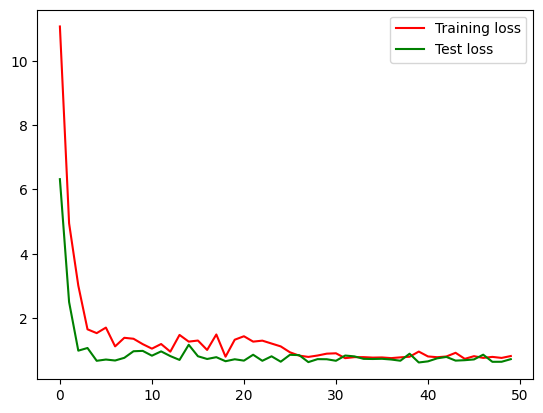

In [25]:
model_nn = Classifier(8)
model = train_evaluate_model(model_nn, loaders,n_epochs=50)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
X_train, _, y_train, _ = train_test_split(
    X_train, y_train, test_size=0.97, random_state=42)
X_train

,age,sex,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
455,62,False,62.000000,0.53157,3.615858,13.563616,5.786800,54.922
115,47,False,0.000000,1.30065,1.560655,36.450320,292.467351,100.580
485,61,False,6.900000,1.90008,4.458313,163.837170,819.146000,573.508
102,51,False,6.940000,0.19227,0.571181,3.099211,39.729131,0.000
437,62,False,143.000000,0.45240,3.900891,207.307240,164.256618,709.664
470,76,False,198.000000,0.18096,1.013392,123.010000,929.408000,0.000
5,53,False,0.000000,0.84825,0.003393,62.126000,59.793000,0.000
152,58,True,0.000000,1.19886,3.043465,37.135014,167.871849,114.798
4,62,False,9.000000,0.21489,0.000860,65.540000,41.088000,0.000
91,38,True,0.139962,0.30537,0.001221,9.572190,0.023819,0.000


In [17]:
reduced_loaders = make_loaders(X_train, y_train, X_test, y_test)

Finished epoch 50, train loss 0.16995859146118164, test loss 6.9370942115783695

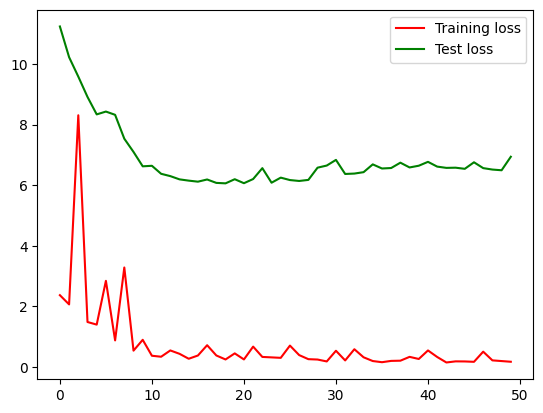

In [36]:
model_nn = Classifier(8)
model = train_evaluate_model(model_nn,reduced_loaders, n_epochs=50)

Finished epoch 300, train loss 0.5871621370315552, test loss 1.5187232494354248

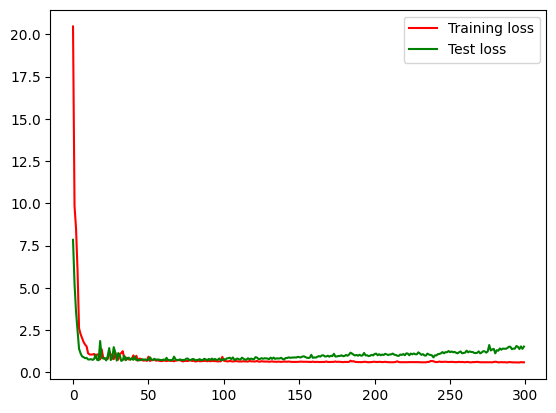

In [54]:
model_nn = Classifier(8)
model = train_evaluate_model(model_nn,loaders, n_epochs=300)

# Случайные целевые переменные при обучении

In [131]:
class ComplexClassifier(nn.Module):
    def __init__(self, n_input_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_input_features, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 32)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(32, 64)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(64, 128)
        self.act4 = nn.ReLU()
        self.hidden5 = nn.Linear(128, 256)
        self.act5 = nn.ReLU()
        self.output = nn.Linear(256, 1)
        self.act_output = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.act5(self.hidden5(x))
        x = self.act_output(self.output(x))
        return x
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


In [125]:
y_train_rand = pd.Series(choices(list(y_train), k= y_train.size))

In [126]:
loaders = make_loaders(X_train, y_train_rand, X_test, y_test)

Finished epoch 50, train loss 1.0015519857406616, test loss 2.0910649299621587

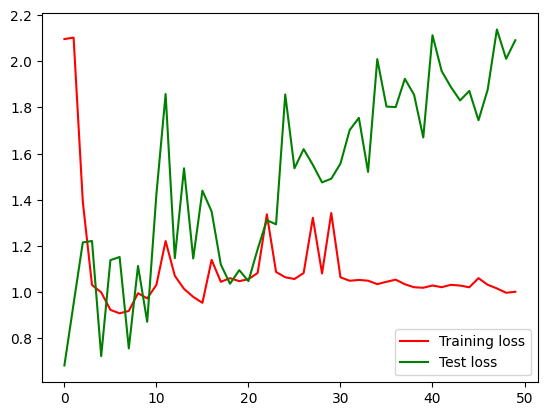

In [127]:
model_nn = Classifier(8)
model = train_evaluate_model(model_nn,loaders, n_epochs=50)

Finished epoch 50, train loss 1.0527899265289307, test loss 3.8582711219787598

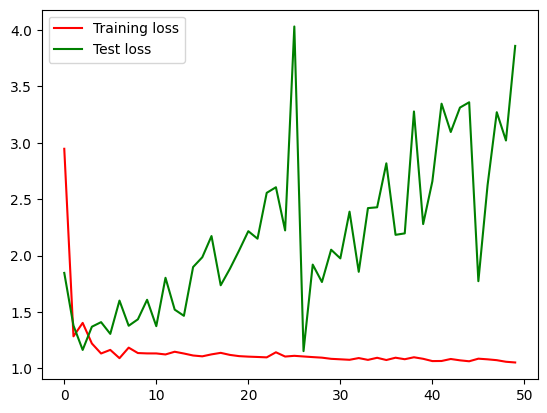

In [132]:
model_nn = ComplexClassifier(8)
model = train_evaluate_model(model_nn,loaders, n_epochs=50)